In [1]:
import open_clip
import torch
from tqdm import tqdm
import torch

/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/custom_envs/icl/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [10]:
import random
val_dir = "/scratch/workspace/dsaluru_umass_edu-email/imagenet/imagenet/val"
random.seed(42)

with open("/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/icl-on-VLMs/flamingo/classification/imagenet/LOC_synset_mapping.txt", 'r') as f:
    mapping = f.readlines()
file_to_label_dict = {x.split(" ")[0] : (" ".join(x.replace("\n", "").lower().split(" ")[1:])).split(", ") for x in mapping}
all_folder_names = list(file_to_label_dict.keys())

final_folder_names = random.sample(all_folder_names, 200)
final_folder_names = final_folder_names[:100]
final_folder_names = [x for x in all_folder_names if x not in final_folder_names]
final_folder_names[:10]

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01514668',
 'n01514859',
 'n01518878',
 'n01530575']

In [12]:
import os
folder_to_files = {}
folder_to_other_folders = {}

for folder in final_folder_names:
    folder_dir = f"{val_dir}/{folder}/"
    other_folders = [x for x in final_folder_names if x != folder]
    folder_to_other_folders[folder] = other_folders
    all_folder_files = os.listdir(folder_dir)
    folder_to_files[folder] = random.sample(all_folder_files, 1)

In [14]:
import pandas as pd
file_df = pd.DataFrame(folder_to_files.items(), columns=['folder', 'filename'])
print(file_df.shape)
file_df.head(2)

(900, 2)


,folder,filename
0,n01440764,[ILSVRC2012_val_00029930.JPEG]
1,n01443537,[ILSVRC2012_val_00013513.JPEG]


In [22]:
val_dir = "/scratch/workspace/dsaluru_umass_edu-email/imagenet/imagenet/val"
file_df['image_path'] = file_df.apply(lambda x: f"{val_dir}/{x['folder']}/{x['filename'][0]}", 1)
file_df.head(3)

,folder,filename,image_path
0,n01440764,[ILSVRC2012_val_00029930.JPEG],/scratch/workspace/dsaluru_umass_edu-email/ima...
1,n01443537,[ILSVRC2012_val_00013513.JPEG],/scratch/workspace/dsaluru_umass_edu-email/ima...
2,n01484850,[ILSVRC2012_val_00004311.JPEG],/scratch/workspace/dsaluru_umass_edu-email/ima...


In [23]:
import os
file_df['image_path'].apply(lambda x: os.path.exists(x)).value_counts()

image_path
True    900
Name: count, dtype: int64

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
class RICES:
    def __init__(
        self,
        vision_encoder_path="ViT-B-32",
        vision_encoder_pretrained="openai"
    ):

        # Load the model and processor
        vision_encoder, _, image_processor = open_clip.create_model_and_transforms(
            vision_encoder_path,
            pretrained=vision_encoder_pretrained,
        )
        self.model = vision_encoder.to("cuda")
        self.image_processor = image_processor

    def get_rice_embedding(self, image_path):
        """
        Compute RICE embedding for a single image.
        Args:
            image_path (str): Path to the image.
        Returns:
            torch.Tensor: Normalized RICE embedding.
        """
        self.model.eval()
        with torch.no_grad():
            image = Image.open(image_path)#.convert("RGB")
            input_tensor = self.image_processor(image).unsqueeze(0).to("cuda")
            embedding = self.model.encode_image(input_tensor)
            embedding /= embedding.norm(dim=-1, keepdim=True)
        return embedding.cpu()

    def get_rice_embeddings_for_list(self, image_paths):
        """
        Compute RICE embeddings for a list of image paths.
        Args:
            image_paths (list): List of image paths.
        Returns:
            torch.Tensor: Stacked embeddings for all images in the list.
        """
        embeddings = []
        for image_path in tqdm(image_paths, desc="Generating embeddings for list"):
            embeddings.append(self.get_rice_embedding(image_path))
        return torch.cat(embeddings)

    def find_top_k_similar(self, query_image_path, reference_embeddings, num_examples):
        """
        Find the top-k most similar images from a list of precomputed embeddings.
        Args:
            query_image_path (str): Path to the query image.
            reference_embeddings (torch.Tensor): Precomputed RICE embeddings.
            num_examples (int): Number of most similar images to retrieve.
        Returns:
            list: Indices of the top-k similar images.
        """
        self.model.eval()
        with torch.no_grad():
            query_embedding = self.get_rice_embedding(query_image_path)
            similarity = (query_embedding @ reference_embeddings.T).squeeze()
            indices = similarity.argsort(dim=-1, descending=True)[:num_examples]
        return indices.tolist()

    def plot_top_k_similar(self, query_image_path, reference_image_paths, reference_embeddings, num_examples):
        """
        Plot the query image alongside its top-k similar images.
        Args:
            query_image_path (str): Path to the query image.
            reference_image_paths (list): List of paths for reference images.
            reference_embeddings (torch.Tensor): Precomputed embeddings of reference images.
            num_examples (int): Number of most similar images to display.
        """
        # Fetch indices of the top-k similar images
        top_k_indices = self.find_top_k_similar(query_image_path, reference_embeddings, num_examples)
        
        # Load the query image
        query_image = Image.open(query_image_path).convert("RGB")
        
        # Load the top-k similar images
        similar_images = [Image.open(reference_image_paths[i]).convert("RGB") for i in top_k_indices]

        # Plot the query image and top-k similar images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, num_examples + 1, 1)
        plt.imshow(query_image)
        plt.axis("off")
        plt.title("Query Image")
        
        for i, img in enumerate(similar_images):
            plt.subplot(1, num_examples + 1, i + 2)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Similar {i+1}")

        plt.tight_layout()
        plt.show()

In [25]:
rice = RICES()

In [26]:
reference_image_paths = file_df['image_path'].tolist()
reference_embeddings = rice.get_rice_embeddings_for_list(reference_image_paths)

Generating embeddings for list: 100%|██████████| 900/900 [01:06<00:00, 13.59it/s]


In [27]:
len(reference_embeddings[0])

512

In [28]:
import random
idx = random.randint(0, len(file_df)-1)
sample = file_df.iloc[idx]

In [31]:
# pd.DataFrame(list(zip(reference_image_paths, reference_embeddings)), columns=['image_path', 'rice_embeddings']).to_pickle('rice_embeddings_demonstrations.pickle')

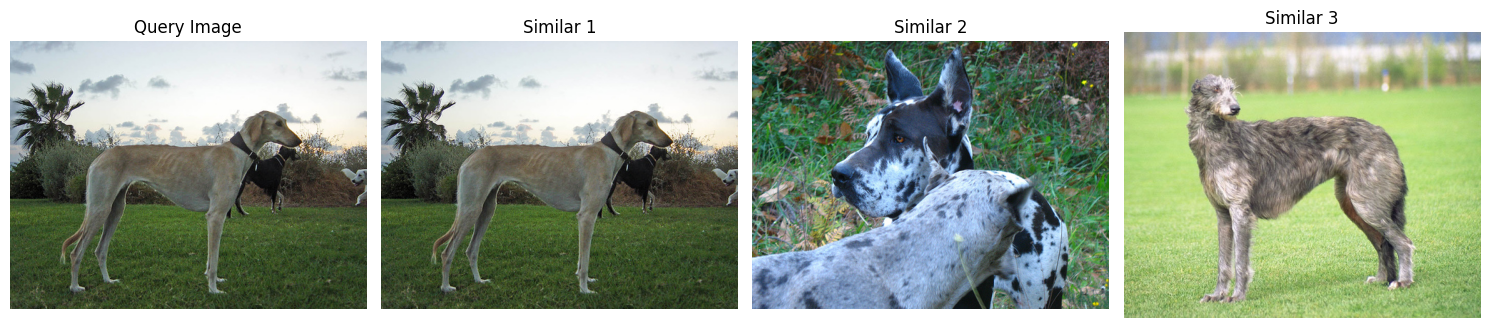

In [30]:
query_image_path = sample['image_path']
rice.plot_top_k_similar(
    query_image_path=query_image_path,
    reference_image_paths=reference_image_paths,
    reference_embeddings=reference_embeddings,
    num_examples=3  # Top 3 similar images
)

In [32]:
1

1

In [35]:
import scipy.io
import numpy as np

# Load the .mat file
filepath = "/scratch/workspace/dsaluru_umass_edu-email/stanford_cars/stanford_cars"
mat_data = scipy.io.loadmat(f'{filepath}/cars_annos.mat')

# mat_data is now a dictionary containing your variables
# To see what variables are in the file:
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])


In [52]:
mat_data['annotations'][0][0]

(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8))

In [55]:
for ele in mat_data['annotations'][0][0]:
    print(ele)

['car_ims/000001.jpg']
[[112]]
[[7]]
[[853]]
[[717]]
[[1]]
[[0]]


In [56]:
mat_data['class_names'][0][0]

array(['AM General Hummer SUV 2000'], dtype='<U26')

In [57]:
mat_data['class_names'][0][7]

array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40')